<a href="https://colab.research.google.com/github/JJThoms1/05_transfer_learning_in_tensorflow_part_2_fine_tuning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 2: Fine-Tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

In [1]:
# Check if we're using a GPU
!nvidia-smi

Tue Oct  8 15:14:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this would be tedious.

So, it's a good idea to put functions you'd like to use again in a script you can download and import into our notebooks (or elsewhere).

We've done this for some of the functions we've used perviously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-10-08 15:14:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-10-08 15:14:32 (106 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑 **Note:** If you're running this notebook in Google Colab, when it times our colab will delete `helper_functions.py` so you'll have to redownload it if you want to access your helper functions.

# Let's get some data

This time we're going to see how we can use the pretrained models within tf.keras.applications. And apply the toward our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-10-08 15:14:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.207, 142.251.10.207, 142.251.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  20.3MB/s    in 9.4s    

2024-10-08 15:14:46 (17.2 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirectories are in our database
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [6]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [7]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[4.35011139e+01 7.82198715e+01 7.19787979e+01]
   [4.48158493e+01 7.94040146e+01 7.52433014e+01]
   [4.74520073e+01 7.92075882e+01 7.85691986e+01]
   ...
   [1.45043503e+02 1.53257767e+02 1.37829239e+02]
   [1.45143951e+02 1.56143951e+02 1.42143951e+02]
   [1.35776596e+02 1.46776596e+02 1.32776596e+02]]

  [[4.76026764e+01 7.84933014e+01 6.81272278e+01]
   [4.92299118e+01 8.04274597e+01 7.31752243e+01]
   [4.94609375e+01 8.06104889e+01 7.68973236e+01]
   ...
   [1.43156250e+02 1.51370514e+02 1.35941986e+02]
   [1.38706436e+02 1.49706436e+02 1.35706436e+02]
   [1.34893951e+02 1.45893951e+02 1.31893951e+02]]

  [[4.70725441e+01 7.24609375e+01 5.37901764e+01]
   [4.89397354e+01 7.67299118e+01 6.29709816e+01]
   [4.60178566e+01 7.46305771e+01 6.49910736e+01]
   ...
   [1.42000000e+02 1.50214264e+02 1.34785736e+02]
   [1.36610474e+02 1.47610474e+02 1.33610474e+02]
   [1.34809158e+02 1.45809158e+02 1.31809158e+02]]

  ...

  [[1.80915177e+00 3.69977689e+00 7.40290165e+00]
   [5

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The squential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional_api

In [13]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pretrained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of our base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model
history_10_percent = model_0.fit(train_data_10_percent,
                         epochs=5,
                         steps_per_epoch=len(train_data_10_percent),
                         validation_data=test_data,
                         validation_steps=int(0.25 * len(test_data)),
                         callbacks=[create_tensorboard_callback(dir_name="transfer learning",
                                                                experiment_name="10_percent_feature_extraction")])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer learning/10_percent_feature_extraction/20241008-151600
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 865ms/step - accuracy: 0.2528 - loss: 2.1192 - val_accuracy: 0.6727 - val_loss: 1.3702
Epoch 2/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6842 - val_loss: 1.3644
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.7209 - loss: 1.2555 - val_accuracy: 0.7812 - val_loss: 0.9863
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7961 - val_loss: 0.9385
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8048 - loss: 0.9113 - val_accuracy: 0.8676 - val_loss: 0.7271


In [14]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.8119 - loss: 0.7852


[0.782931923866272, 0.8163999915122986]

In [15]:
# Check the layers of our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_layer
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [16]:
# How about we get a summary of our base model
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, None, None, 3)  │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, None, None, 3)  │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, None, None, 3)  │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, None, None, 32) │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, None, None, 32) │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, None, None, 32) │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, None, None, 32) │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, None, None, 32) │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, None, None, 32) │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [17]:
# How about a summary of our whole model
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,088,003 (15.59 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 25,622 (100.09 KB)

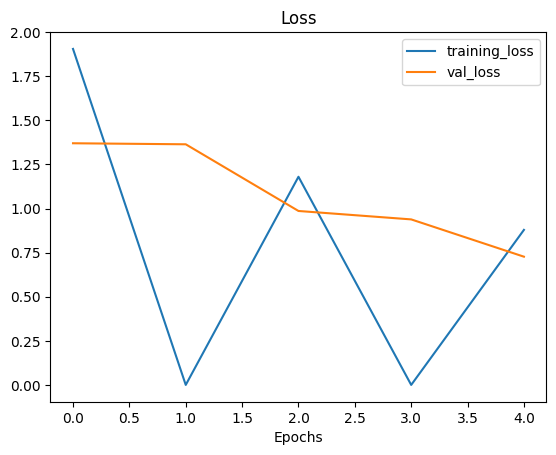

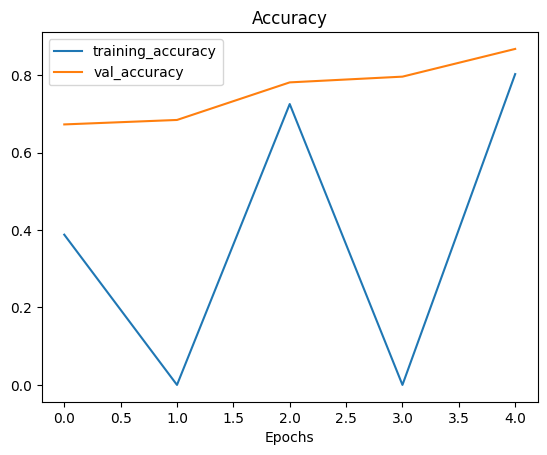

In [18]:
# Check out our models training curves
plot_loss_curves(history_10_percent)